# Modeling
In this notebook I will create some deep learning models to address the colorization task.

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf

from keras.layers import Conv2D, UpSampling2D, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from sklearn.model_selection import train_test_split

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [4]:
dataset_path = "../preprocessed/"
path = '../../dataset/'
models_path = "../../models/"
results_path = "../../results/"

In [6]:
N = 25000
W = 128
H = 128
SIZE = 256

## Load datasets

In [4]:
# resized = []
# grayscaled = []

In [8]:
# for f in tqdm(os.listdir(dataset_path+"resized/")):
#     resized = np.append(resized,np.load(dataset_path+"resized/"+f)["arr_0"])

In [ ]:
# assert resized.shape == (N,W,H,3)

## Pre-processing

In [7]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory(path+"download/", 
                                          target_size=(SIZE, SIZE), 
                                          batch_size=1000, 
                                          class_mode=None)

Found 1025 images belonging to 2 classes.


In [8]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X =[]
Y =[]
for img in tqdm(train[0]):
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
        #so we divide the values by 128 to restrict values to between -1 and 1.
    except:
        print('error')
        
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) # dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


(1000, 256, 256, 1)
(1000, 256, 256, 2)


In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
print("Train",X_train.shape, Y_train.shape)
print("Test",X_test.shape, Y_test.shape)

Train (900, 256, 256, 1) (900, 256, 256, 2)
Test (100, 256, 256, 1) (100, 256, 256, 2)


## Training

### Simple Deep AutoEncoder with 3+2 dense layers

This model is not powerful enough to reproduce the task of colorization.
With less than 85k trainable parameters, a simple deep autoencoder with only dense layers is not a valid option.

More important, I can clearly see that this model is not suitable for this task because even with a small dataset (100 images) and lots of epochs (50) it is not able to overfit the training data.

In [56]:
# Encoder
model = Sequential(name=("AE_Simple_Dense"))
model.add(Dense(128,activation="relu", input_shape=(SIZE, SIZE, 1)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))

# Decoder
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))

# output layer
model.add(Dense(2, activation='tanh'))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

### Simple Deep AutoEncoder with 3+2 convolutional layers

In [61]:
#Encoder
model = Sequential(name=("AE_Simple"))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))          

# output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

### Complex Deep AutoEncoder with several layers and upsampling

In [54]:
#Encoder
model = Sequential(name=("AE_Complex"))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer="adam", loss='mse' , metrics=['accuracy'])

### Hyper-parameter selection

Related to model architecture
- number of layers
- conv vs no-conv
- upsampling y/n
- maxpool y/n
- batch norm y/n

Related to training
- epochs
- validation split
- batch size

In [62]:
model.summary()

Model: "AE_Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 256, 256, 128)     1280      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 256, 256, 32)      36896     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 256, 256, 32)      18464     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 256, 256, 2)       578       
Total params: 84,962
Trainable params: 84,962
Non-trainable params: 0
_____________________________________________________

In [ ]:
history = model.fit(X,Y,validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
25/25 [==============================] - 341s 14s/step - loss: 0.1878 - accuracy: 0.5111 - val_loss: 0.0265 - val_accuracy: 0.4615
Epoch 2/50
25/25 [==============================] - 335s 13s/step - loss: 0.0240 - accuracy: 0.4926 - val_loss: 0.0251 - val_accuracy: 0.4639
Epoch 3/50
25/25 [==============================] - 368s 15s/step - loss: 0.0237 - accuracy: 0.4752 - val_loss: 0.0250 - val_accuracy: 0.5651
Epoch 4/50
25/25 [==============================] - 365s 15s/step - loss: 0.0232 - accuracy: 0.5542 - val_loss: 0.0257 - val_accuracy: 0.4867
Epoch 5/50
25/25 [==============================] - 366s 15s/step - loss: 0.0235 - accuracy: 0.5655 - val_loss: 0.0243 - val_accuracy: 0.5991
Epoch 6/50
25/25 [==============================] - 374s 15s/step - loss: 0.0233 - accuracy: 0.6202 - val_loss: 0.0242 - val_accuracy: 0.5458
Epoch 7/50
25/25 [==============================] - 371s 15s/step - loss: 0.0235 - accuracy: 0.6093 - val_loss: 0.0244 - val_accuracy: 0.5375
Epoch 

In [59]:
def plot_history(history):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    ax = axes.ravel()
    
    # accuracy
    ax[0].plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    ax[1].plot(history.history['loss'])
    if 'val_loss' in history.history:
        ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epochs')
    ax[1].legend(['train', 'validation'], loc='upper right')
    
    fig.tight_layout()
    plt.show()      

In [ ]:
plot_history(history)

In [32]:
model.save(models_path+model.name)

INFO:tensorflow:Assets written to: ../../models/AE_Simple_Dense\assets


---

In [163]:
# choose model to load
model_name = model.name
# model_name = "colorize_autoencoder_VGG16_10000.model"

In [ ]:
# loads a model from disk into memory
model = tf.keras.models.load_model(
    models_path+model_name,
    custom_objects=None,
    compile=True)

## Testing

Final testing phase.

> I do **not** validate on this set, these metrics are meant just to be _reported_ and not used as indicators.

In this phase I will also compare some other algorithms.

In [ ]:
train_acc = 0
valid_acc = 0
test_acc = 0

test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=128)

print(f"Accuracy\ntrain: {train_acc}\nvalid: {valid_acc}\ntest: {test_acc}")

## Visualization

In [38]:
def plot_comparison(img_resized,img_recolored):     
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax = axes.ravel()

    ax[0].imshow(img_resized.astype('uint8'))
    ax[0].set_title("Resized")
    ax[1].imshow(img_recolored)
    ax[1].set_title("Recolored")

    fig.tight_layout()
    plt.show()      

landscapes_1.jpeg


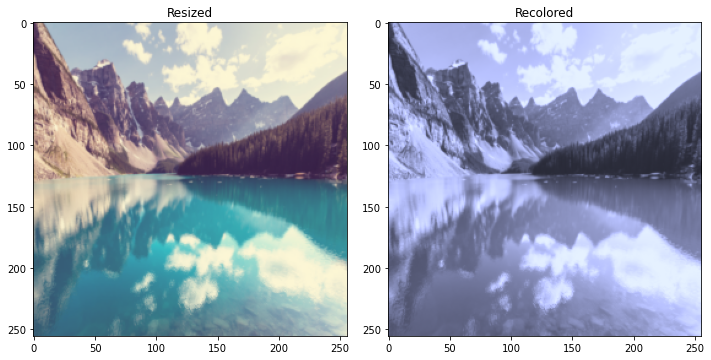

landscapes_10.jpeg


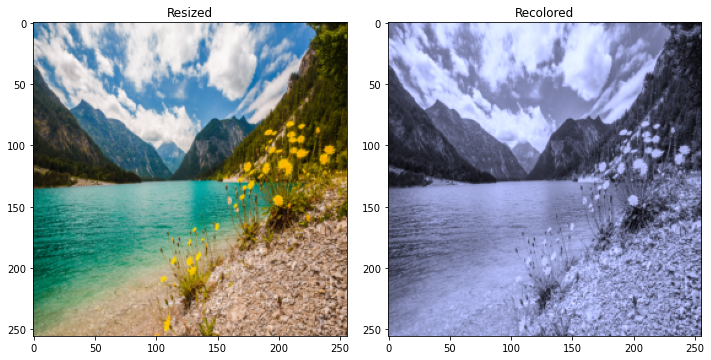

landscapes_11.jpeg


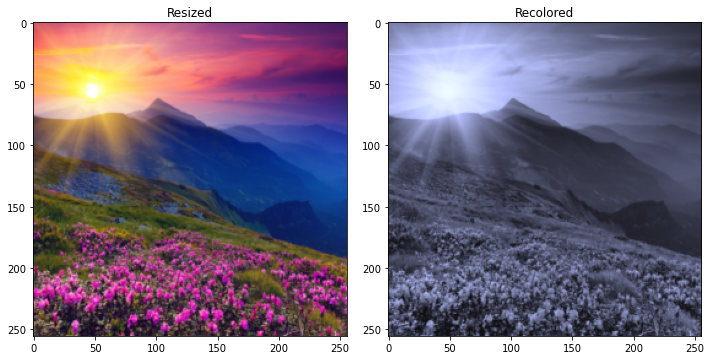

landscapes_12.jpeg


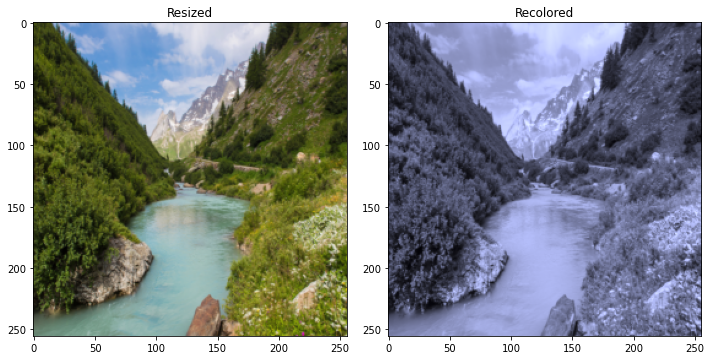

landscapes_13.jpeg


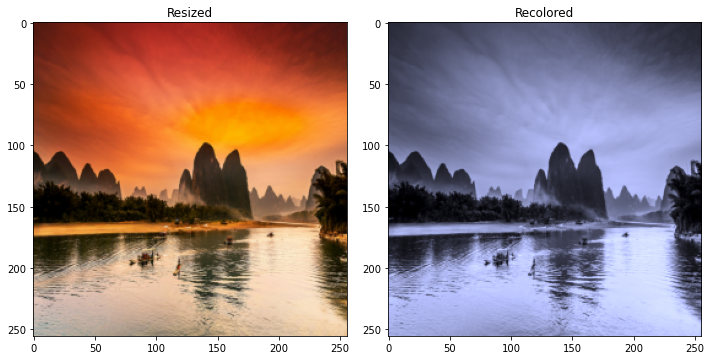

landscapes_14.jpeg


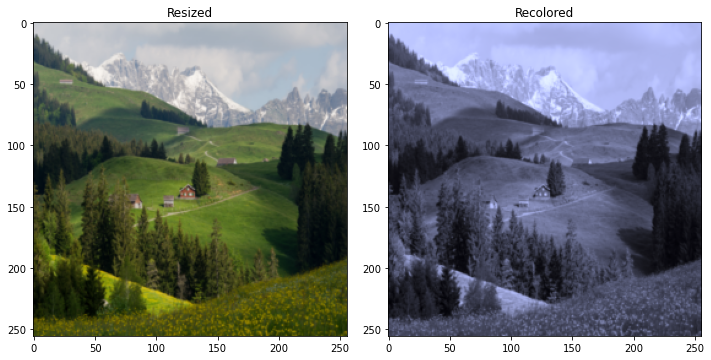

landscapes_15.jpeg


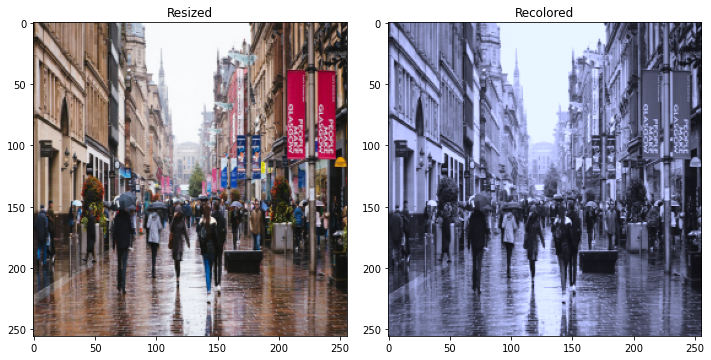

landscapes_16.png


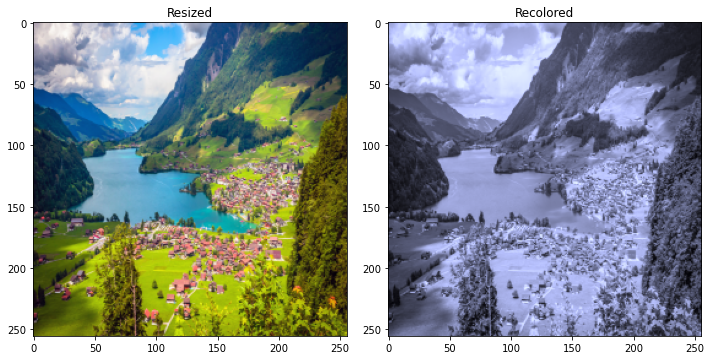

landscapes_17.jpeg


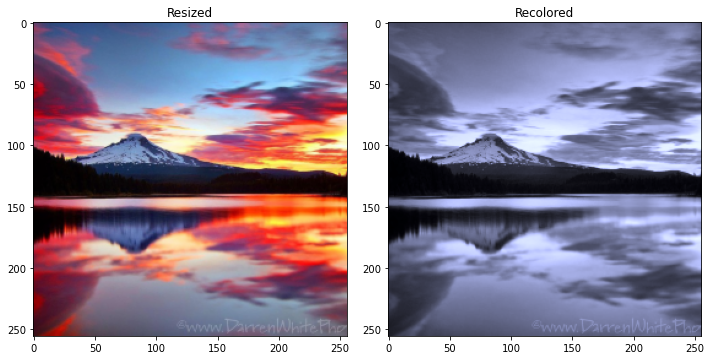

landscapes_18.jpeg


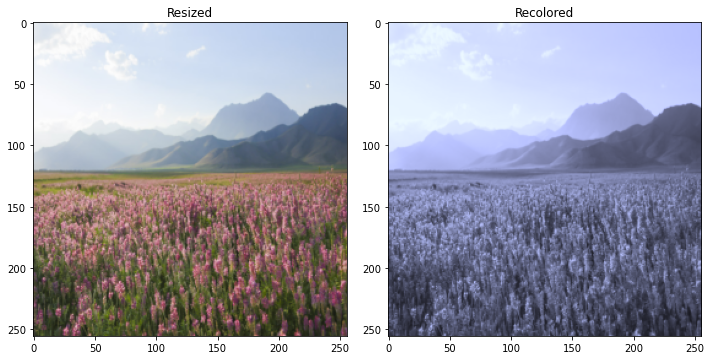

In [40]:
for img_path in os.listdir(path+"download/landscapes/")[:10]:    
    img1_color=[]
    img1=img_to_array(load_img(path+'download/landscapes/'+img_path))
    img1 = resize(img1 ,(SIZE,SIZE))
    img1_color.append(img1)
    img1_color = np.array(img1_color, dtype=float)
    img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
    img1_color = img1_color.reshape(img1_color.shape+(1,))

    output1 = model.predict(img1_color)
    output1 = output1*128
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img1_color[0][:,:,0]
    result[:,:,1:] = output1[0]

    imsave(results_path+img_path, (lab2rgb(result)*255).astype(np.uint8))
    recolored = lab2rgb(result)
    plot_comparison(img1, recolored)